# Validação Cruzada Time Series Split (teste)

In [ ]:
from modulos import eda
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

2025-08-01 20:32:22.524216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754094742.535752 3299191 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754094742.539246 3299191 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754094742.549563 3299191 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754094742.549574 3299191 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754094742.549575 3299191 computation_placer.cc:177] computation placer alr

In [2]:
dados_manaus = eda.data_processing('Cotas extraidas',
                                   '1985-01-01',
                                   '2024-12-31',
                                   ['dados_diarios_estacao_14990000.csv'])
dados_manaus

,14990000
Data,
1985-01-01,2169.0
1985-01-02,2178.0
1985-01-03,2186.0
1985-01-04,2194.0
1985-01-05,2201.0
...,...
2024-12-27,1751.0
2024-12-28,1769.0
2024-12-29,1785.0


In [3]:
def create_multi_step_dataset(series, janela, n_steps):
    X, y = [], []
    for i in range(len(series) - janela - n_steps + 1):
        X.append(series[i:i+janela])
        y.append(series[i+janela:i+janela+n_steps])
    return np.array(X), np.array(y)

In [4]:
def criar_lstm(units: int, janela: int, n_steps: int, activation='tanh'):
    model = keras.models.Sequential([
        keras.layers.Input(shape=(janela, 1)),
        keras.layers.LSTM(units, activation=activation),
        keras.layers.Dense(n_steps)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanAbsoluteError()])

    return model

In [5]:
def criar_mlp(hidden_layers: tuple, janela: int, n_steps:int, activation='relu'):
    model = keras.models.Sequential([
        keras.layers.Input(shape=(janela,)),
        keras.layers.Dense(hidden_layers[0], activation=activation),
        keras.layers.Dense(hidden_layers[1], activation=activation),
        keras.layers.Dense(n_steps)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanAbsoluteError()])

    return model

In [6]:
janela = 15
steps = 15
X, y = create_multi_step_dataset(dados_manaus['14990000'].values, janela, steps)

In [7]:
tscv = TimeSeriesSplit(n_splits=5)
r2_mlp_list = []
r2_lstm_list = []

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    # Separação dos conjuntos de treino e teste
    x_train_raw, x_test_raw = X[train_idx], X[test_idx]
    y_train_raw, y_test_raw = y[train_idx], y[test_idx]

    # Cria novo scaler a cada fold
    scaler_x = MinMaxScaler()
    x_train_scaled = scaler_x.fit_transform(x_train_raw)
    x_test_scaled = scaler_x.transform(x_test_raw)

    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train_raw)

    # Treinamento
    mlp = criar_mlp((15, 15), janela, steps)
    mlp.fit(x_train_scaled, y_train_scaled, epochs=100, verbose=0, callbacks=early_stop)

    lstm = criar_lstm(15, janela, steps)
    lstm.fit(x_train_scaled, y_train_scaled, epochs=100, verbose=0, callbacks=early_stop)

    # Predição
    y_pred_mlp = mlp.predict(x_test_scaled)
    y_pred_mlp_inverso = scaler_y.inverse_transform(y_pred_mlp)

    y_pred_lstm = lstm.predict(x_test_scaled)
    y_pred_lstm_inverso = scaler_y.inverse_transform(y_pred_lstm)

    # Avaliação
    r2_mlp = r2_score(y_test_raw, y_pred_mlp_inverso)
    r2_mlp_list.append(r2_mlp)

    r2_lstm = r2_score(y_test_raw, y_pred_lstm_inverso)
    r2_lstm_list.append(r2_lstm)

    print(f"Fold {fold+1} — MLP R²: {r2_mlp:.4f}; LSTM R²: {r2_lstm:.4f}")

I0000 00:00:1754094744.106419 3299191 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10151 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1754094745.130987 3299561 service.cc:152] XLA service 0x71e3e00089f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754094745.131005 3299561 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2025-08-01 20:32:25.162029: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754094745.242589 3299561 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754094745.788636 3299561 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 1 — MLP R²: 0.9866; LSTM R²: 0.9932
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Fold 2 — MLP R²: 0.9933; LSTM R²: 0.9940
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 3 — MLP R²: 0.9964; LSTM R²: 0.9960
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 4 — MLP R²: 0.9940; LSTM R²: 0.9960
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Fold 5 — MLP R²: 0.9947; LSTM R²: 0.9963


In [8]:
r2_mlp_mean, r2_mlp_std = np.mean(r2_mlp_list), np.std(r2_mlp_list)
r2_lstm_mean, r2_lstm_std = np.mean(r2_lstm_list), np.std(r2_lstm_list) 

print(f"MLP R² = {r2_mlp_mean:.4f} +- {r2_mlp_std:4f}")
print(f"LSTM R² = {r2_lstm_mean:.4f} +- {r2_lstm_std:4f}")

MLP R² = 0.9930 +- 0.003358
LSTM R² = 0.9951 +- 0.001259


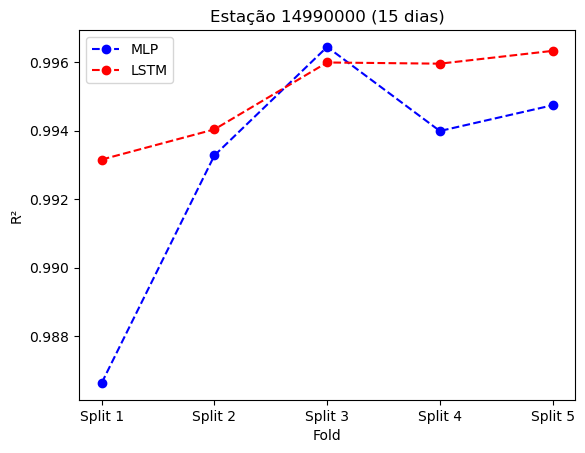

In [9]:
plt.plot(r2_mlp_list, 'bo', linestyle='--', label='MLP')
plt.plot(r2_lstm_list, 'ro', linestyle='--', label='LSTM')
plt.legend()
plt.xticks([0, 1, 2, 3, 4], [f'Split {i+1}' for i in range(5)])
plt.xlabel('Fold')
plt.ylabel('R²')
plt.title(f'Estação 14990000 ({steps} dias)')
plt.show()